In [1]:
import pandas as pd
import os
import zipfile
import StringIO
import requests
import statsmodels.api as sm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
%matplotlib inline

/bbkinghome/basilh/.local/lib/python2.7/site-packages/pandas/core/nanops.py:39: UserWarning: The installed version of bottleneck 0.7.0 is not supported in pandas and will be not be used
The minimum supported version is 1.0.0

  ver=ver, min_ver=_MIN_BOTTLENECK_VERSION), UserWarning)


# Death data

In [112]:
BASE_URL = "https://www.nber.org/mortality/{0}/mort{0}.csv.zip"
DOWNLOAD_DEST_BASE = 'nchs_mcd_rawdata'
START_YEAR = 1979
END_YEAR = 2017

In [113]:
# If raw data folder doesn't exist, create it
if not os.path.exists(DOWNLOAD_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(DOWNLOAD_DEST_BASE))

In [114]:
def download_raw_data_by_year(year, base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    """
    See documentation stuff here:
    https://www.nber.org/data/vital-statistics-mortality-data-multiple-cause-of-death.html
    """
    year = str(year)
    
    # Check if already exists
    if os.path.exists(os.path.join(download_dest_base, '{0}.csv'.format(year))):
        print "Already have data for {0}".format(year)
        return
    
    # Specify file locations
    url = base_url.format(year)
    download_dest = os.path.join(download_dest_base, year)

    # Download data
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(download_dest)

    # Move CSV to main directory and delete empty folder
    current_filename = os.path.join(download_dest, 'mort{0}.csv'.format(year))
    new_filename = os.path.join(download_dest_base, '{0}.csv'.format(year))
    os.rename(current_filename, new_filename)
    os.rmdir(os.path.join(download_dest_base, year))
    
    print "Downloaded data for {0}".format(year)

In [115]:
def download_raw_data(start_year=START_YEAR, end_year=END_YEAR, 
                      base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    years = range(start_year, end_year+1)
    
    for year in years:
        download_raw_data_by_year(year, base_url, download_dest_base)

In [116]:
download_raw_data()

Already have data for 1979
Already have data for 1980
Already have data for 1981
Already have data for 1982
Already have data for 1983
Already have data for 1984
Already have data for 1985
Already have data for 1986
Already have data for 1987
Already have data for 1988
Already have data for 1989
Already have data for 1990
Already have data for 1991
Already have data for 1992
Already have data for 1993
Already have data for 1994
Already have data for 1995
Already have data for 1996
Already have data for 1997
Already have data for 1998
Already have data for 1999


KeyboardInterrupt: 

# Population data

In [7]:
OTHER_DATA_DEST_BASE = 'other_data'

In [8]:
# If raw data folder doesn't exist, create it
if not os.path.exists(OTHER_DATA_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(OTHER_DATA_DEST_BASE))

### 2010-2018

In [9]:
# Source url: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Description: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.pdf
POP_DATA_URL_2010 = 'https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.csv'

In [10]:
def download_2010_pop_data(pop_data_url_2010=POP_DATA_URL_2010):
    """
    Download population data from 2010-2018
    """
    # Download
    pop_data_2010_raw = pd.read_csv(pop_data_url_2010, index_col=None, header=0)
    
    # Clean
    col_map = {
        c: c[-4:]
        for c in pop_data_2010_raw.columns if 'POPESTIMATE' in c
    }
    col_map['AGE'] = 'age'
    col_map['SEX'] = 'sex'
    gender_map = {
        0: 'total',
        1: 'male',
        2: 'female',
    }

    pop_data_2010 = pop_data_2010_raw[col_map].rename(columns=col_map)
    pop_data_2010['sex'] = pop_data_2010['sex'].replace(gender_map)
    pop_data_2010['age'] = pop_data_2010['age'].replace(999, 'total')

    pop_data_2010 = (
        pop_data_2010
        .set_index(['sex', 'age'])
        .T
        .sort_index()
    )
    
    # Return
    return pop_data_2010['total'], pop_data_2010['male'], pop_data_2010['female']

In [11]:
def load_pop_data_2010(pop_data_url_2010=POP_DATA_URL_2010, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2010_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2010_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2010_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2010_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2010_total.columns = [int(x) for x in pop_data_2010_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2010-2018 population data"
        pop_data_2010_total, males, females = download_2010_pop_data(pop_data_url_2010)
        
        pop_data_2010_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2010_total

In [12]:
pop_data_2010 = load_pop_data_2010()

Loading other_data/pop_data_2010_total.csv


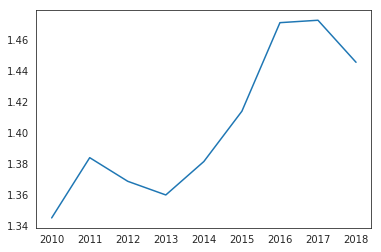

In [13]:
(pop_data_2010[26]*100./pop_data_2010['total']).plot()

### 2000-2009

In [14]:
# Source url: https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-2000-2010-national.html
POP_DATA_URL_2000 = 'https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/national/us-est00int-alldata.csv'

In [200]:
pop_data_2000_raw = pd.read_csv(POP_DATA_URL_2000, index_col=None, header=0)

# Estimates are available for April and July (??), I use July.
pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == 7]

In [202]:
def download_2000_pop_data(pop_data_url_2000=POP_DATA_URL_2000, month=7):
    """
    Download population data from 2000-2009
    Estimates are available for July, and also for April only in 2000 and 2010 (??), so I use July.
    """   
    # Download
    pop_data_2000_raw = pd.read_csv(pop_data_url_2000, index_col=None, header=0)
    
    # Estimates are available for April and July (??), I use July.
    pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == month]

    # Clean
    def clean_pop_2000(df):
        df = df.rename(columns={999: 'total'})
        df.index.name = None
        df.columns.name = None
        return df

    pop_data_2000_total = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_POP')
    pop_data_2000_male = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_MALE')
    pop_data_2000_female = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_FEMALE')

    pop_data_2000_total = clean_pop_2000(pop_data_2000_total)
    pop_data_2000_male = clean_pop_2000(pop_data_2000_male)
    pop_data_2000_female = clean_pop_2000(pop_data_2000_female)
    
    # Return
    return pop_data_2000_total, pop_data_2000_male, pop_data_2000_female

In [252]:
def load_pop_data_2000(pop_data_url_2000=POP_DATA_URL_2000, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2000_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2000_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2000_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2000_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2000_total.columns = [int(x) for x in pop_data_2000_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2000-2009 population data"
        pop_data_2000_total, males, females = download_2000_pop_data(pop_data_url_2000)
        
        pop_data_2000_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2000_total

In [253]:
pop_data_2000 = load_pop_data_2000()

Loading other_data/pop_data_2000_total.csv


### 1990-2000

In [208]:
#https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-1990-2000-national.html
POP_DATA_URL_1990 = 'https://www2.census.gov/programs-surveys/popest/datasets/1990-2000/intercensal/national/us-est90int-07.csv'

In [248]:
def download_1990_pop_data(pop_data_url_1990=POP_DATA_URL_1990, month=7):
    """
    Download population data from 1990-1999
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1990_raw = pd.read_csv(pop_data_url_1990, index_col=None, header=0, skiprows=1)
    
    # Clean
    # Relabel columns
    pop_data_1990 = pop_data_1990_raw.copy()
    pop_data_1990.columns = ['Date', 'Age', 'Total', 'Male', 'Female']
    # Drop bad rows
    pop_data_1990 = pop_data_1990['Int' != pop_data_1990['Date'].str[:3]]
    # Date
    pop_data_1990['Date'] = pd.to_datetime(pop_data_1990['Date'])
    pop_data_1990['Year'] = pop_data_1990['Date'].apply(lambda x: x.year)
    pop_data_1990['Month'] = pop_data_1990['Date'].apply(lambda x: x.month)
    # Age
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('100+', '100')
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('All Age', 'total')
    # Estimates are available quarterly, I use April.
    pop_data_1990 = pop_data_1990[pop_data_1990['Month'] == month]
    
    # Collect
    pop_data_1990_total = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Total')
    pop_data_1990_male = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Male')
    pop_data_1990_female = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1990(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1990_total = clean_pop_1990(pop_data_1990_total)
    pop_data_1990_male = clean_pop_1990(pop_data_1990_male)
    pop_data_1990_female = clean_pop_1990(pop_data_1990_female)
    
    # Return
    return pop_data_1990_total, pop_data_1990_male, pop_data_1990_female

In [254]:
def load_pop_data_1990(pop_data_url_1990=POP_DATA_URL_1990, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1990_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1990_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1990_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1990_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1990_total.columns = [int(x) for x in pop_data_1990_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1990_total, males, females = download_1990_pop_data(pop_data_url_1990)
        
        pop_data_1990_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1990_total

In [255]:
pop_data_1990 = load_pop_data_1990()

Saved other_data/pop_data_1990_total.csv


### 1980-1990

In [344]:
# Source: https://www.census.gov/data/datasets/time-series/demo/popest/1980s-national.html
# Documentation: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/1980-1990/nat-detail-layout.txt
POP_DATA_URLS_1980s = {
    1980: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8081rqi.zip',
    1981: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8182rqi.zip',
    1982: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8283rqi.zip',
    1983: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8384rqi.zip',
    1984: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8485rqi.zip',
    1985: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8586rqi.zip',
    1986: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8687rqi.zip',
    1987: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8788rqi.zip',
    1988: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8889rqi.zip',
    1989: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8990rqi.zip',
}

In [442]:
def download_1980_pop_data_by_year(year, pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                                   other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data for a given year in 1980-1989
    Estimates are available quarterly, I use July.
    """   
    # Download zip for the year
    url = pop_data_urls_1980s[year]
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(other_data_dest_base)    
    
    # Read in data (stored as a string wtf)
    year_str2 = str(year)[-2:]
    year_after_str2 = str(year+1)[-2:]
    raw_data_name = 'E{0}{1}RQI.TXT'.format(year_str2, year_after_str2)
    raw_data_path = os.path.join(other_data_dest_base, raw_data_name)
    raw_data = open(raw_data_path, 'r').readlines()

    pop_data_year = {
        'Month': {},
        'Year': {},
        'Age': {},
        'Total': {},
        'Male': {},
        'Female': {},
    }
    for row_num in range(len(raw_data)):
        row = raw_data[row_num]
        if len(row) < 40:
            continue
        #pop_data_year['series'][row_num] = row[0:2]
        pop_data_year['Month'][row_num] = int(row[2:4])
        pop_data_year['Year'][row_num] = int('19' + row[4:6])
        pop_data_year['Age'][row_num] = int(row[6:10])
        #pop_data_year['blank'][row_num] = row[10:11]
        pop_data_year['Total'][row_num] = int(row[11:21])
        pop_data_year['Male'][row_num] = int(row[21:31])
        pop_data_year['Female'][row_num] = int(row[31:41])
    
    # Clean up
    pop_data_year = pd.DataFrame(pop_data_year)
    os.remove(raw_data_path)
    
    # Clean
    pop_data_year['Age'] = pop_data_year['Age'].replace(999, 'total')
    pop_data_year = pop_data_year[pop_data_year['Year'] == year]
    pop_data_year = pop_data_year[pop_data_year['Month'] == month]

    
    return pop_data_year

In [443]:
def download_1980_pop_data(pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                           other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data from 1980-1989
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1980_dict = {}
    for year in range(1980, 1990):
        pop_data_1980_dict[year] = download_1980_pop_data_by_year(year, pop_data_urls_1980s, 
                                                                  other_data_dest_base, month)
    pop_data_1980 = pd.concat(pop_data_1980_dict.values(), axis=0)
        
    # Collect
    pop_data_1980_total = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Total')
    pop_data_1980_male = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Male')
    pop_data_1980_female = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1980(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1980_total = clean_pop_1980(pop_data_1980_total)
    pop_data_1980_male = clean_pop_1980(pop_data_1980_male)
    pop_data_1980_female = clean_pop_1980(pop_data_1980_female)
    
    # Return
    return pop_data_1980_total, pop_data_1980_male, pop_data_1980_female

In [444]:
def load_pop_data_1980(pop_data_urls_1980s=POP_DATA_URLS_1980s, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1980_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1980_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1980_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1980_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1980_total.columns = [int(x) for x in pop_data_1980_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1980_total, males, females = download_1980_pop_data(pop_data_urls_1980s, other_data_dest_base)
        
        pop_data_1980_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1980_total

In [446]:
pop_data_1980 = load_pop_data_1980()

Loading other_data/pop_data_1980_total.csv


### <1980

In [349]:
#https://www.census.gov/data/tables/time-series/demo/popest/pre-1980-national.html

### Combine

In [447]:
# Note that the "max bucket" varies over time, but doesn't matter for our purposes
# See https://www.census.gov/dataviz/visualizations/055/

In [448]:
dict_of_pop_data = {
    '2010-2017': pop_data_2010,
    '2000-2009': pop_data_2000.loc[2000:2009],
    '1990-1999': pop_data_1990,
    '1980-1989': pop_data_1980,
    #'<1980': None,
}

In [449]:
pop_data = pd.concat(dict_of_pop_data.values(), axis=0)
pop_data = pop_data.fillna(0)
pop_data = pop_data.sort_index()

clear_output() # stupid warning

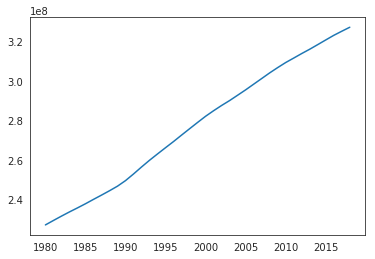

In [450]:
# Sanity check
pop_data['total'].plot()

# Get just suicide data

In [88]:
CLEAN_DATA_BASE = 'cleaned_data'

In [89]:
if not os.path.exists(CLEAN_DATA_BASE):
    os.makedirs(CLEAN_DATA_BASE)
    print "Created", CLEAN_DATA_BASE

In [118]:
# See Hansen and Lang (2011), "Data" section; or individual documentation files linked from NBER
DEATH_VAR_MAP = {}
SUICIDE_VAL_MAP = {}
#for year in range(1968, 1979):
    # ICDA-8
    # https://www.nber.org/mortality/www.cdc.gov/nchs/data/dvs/dt78icd8.pdf
    #DEATH_VAR_MAP[year] = 'ucr34'
    #SUICIDE_VAL_MAP[year] = 350
for year in range(1979, 2000):
    # ICDA-9
    DEATH_VAR_MAP[year] = 'ucr34'
    SUICIDE_VAL_MAP[year] = 350
for year in range(2000, 2018):
    # ICDA-10
    DEATH_VAR_MAP[year] = 'ucr39'
    SUICIDE_VAL_MAP[year] = 40

In [119]:
def get_suicide_data(death_var_map=DEATH_VAR_MAP, suicide_val_map=SUICIDE_VAL_MAP,
                     start_year=START_YEAR, end_year=END_YEAR,
                     raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    for year in reversed(range(start_year, end_year+1)):
        # Check if already exists
        new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        if os.path.exists(new_filename):
            print new_filename, "already exists"
            continue

        # Set appropriate variables
        death_var = death_var_map[int(year)]
        suicide_val = suicide_val_map[int(year)]
        
        # Get data
        get_suicide_data_by_year(death_var, suicide_val, year, raw_data_loc_base, suicide_data_loc_base)

In [120]:
def get_suicide_data_by_year(death_var, suicide_val, year,
                             raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    # Check if already exists
    new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
    if os.path.exists(new_filename):
        print new_filename, "already exists"
        return

    # Load data
    print "Loading", year
    filename = os.path.join(raw_data_loc_base, '{0}.csv'.format(year))
    data = pd.read_csv(filename)

    # Filter to just suicides
    suicide_data = data[data[death_var] == suicide_val]

    # Clean data
    # For years <1978, 'year' is labeled differently
    data['year'] = year
    # Drop bad data
    # TODO: what is going on here
    if year >= 2010:
        prefix = suicide_data['age'].apply(lambda x: int(str(x)[:2]))
        clean_suicide_data = suicide_data[prefix == 10].copy()
        actual_age = clean_suicide_data['age'].apply(lambda x: int(str(x)[2:]))
        clean_suicide_data['actual_age'] = actual_age
    else:
        clean_suicide_data = suicide_data[suicide_data['age'] != 999].copy()
        clean_suicide_data['actual_age'] = clean_suicide_data['age']        

    # Drop irrelevant vars
    final_suicide_data = clean_suicide_data[['sex', 'actual_age', 'monthdth']].copy()
    final_suicide_data = final_suicide_data.rename(columns={'actual_age': 'age', 'monthdth': 'month'})
    final_suicide_data['year'] = year

    # Save data
    final_suicide_data.to_csv(new_filename)
    print "Saved", new_filename

In [121]:
get_suicide_data()

cleaned_data/2017.csv already exists
cleaned_data/2016.csv already exists
cleaned_data/2015.csv already exists
cleaned_data/2014.csv already exists
cleaned_data/2013.csv already exists
cleaned_data/2012.csv already exists
cleaned_data/2011.csv already exists
cleaned_data/2010.csv already exists
cleaned_data/2009.csv already exists
cleaned_data/2008.csv already exists
cleaned_data/2007.csv already exists
cleaned_data/2006.csv already exists
cleaned_data/2005.csv already exists
cleaned_data/2004.csv already exists
cleaned_data/2003.csv already exists
cleaned_data/2002.csv already exists
cleaned_data/2001.csv already exists
cleaned_data/2000.csv already exists
cleaned_data/1999.csv already exists
Loading 1998


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (8,9,10,11,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1998.csv
Loading 1997
Saved cleaned_data/1997.csv
Loading 1996
Saved cleaned_data/1996.csv
Loading 1995


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (8,10,11,12,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1995.csv
Loading 1994
Saved cleaned_data/1994.csv
Loading 1993


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (9,11,12,13,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1993.csv
Loading 1992
Saved cleaned_data/1992.csv
Loading 1991


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1991.csv
Loading 1990


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,20,21,98,103,108,113,118,123,128,133,138,178,180,182,184,186,188,190) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1990.csv
Loading 1989


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,20,98,103,108,113,118,123,128,133,138,143,178,180,182,184,186,188,190,192) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1989.csv
Loading 1988


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,95,100,105,110,115,120,125,130,170,172,174,176,178,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1988.csv
Loading 1987


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,89,94,99,104,109,114,119,124,169,171,173,175,177,179,181) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1987.csv
Loading 1986
Saved cleaned_data/1986.csv
Loading 1985


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,94,99,104,109,114,119,124,129,169,171,173,175,177,179,181) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1985.csv
Loading 1984


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,89,94,99,104,109,114,119,124,129,169,171,173,175,177,179,181,183) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1984.csv
Loading 1983
Saved cleaned_data/1983.csv
Loading 1982


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,88,93,98,103,108,113,118,123,128,133,168,170,172,174,176,178,180,182) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1982.csv
Loading 1981


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,34,77,82,87,92,97,102,107,112,157,159,161,163,165,167,169,171) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1981.csv
Loading 1980
Saved cleaned_data/1980.csv
Loading 1979


/bbkinghome/basilh/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (2,10,12,13,14,18,81,86,91,96,101,106,111,116,121,126,156,158,160,162,164,166,168,170,172) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data/1979.csv


# Computing suicide rates

### Computing

In [274]:
START_YEAR = 1990

In [275]:
def stack_suicide_data(start_year=START_YEAR, end_year=END_YEAR, suicide_data_loc_base=CLEAN_DATA_BASE):
    data = {}
    for year in range(start_year, end_year+1):
        filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        data[year] = pd.read_csv(filename, index_col=0)
        
    stacked_data = pd.concat(data.values(), axis=0)
    return stacked_data

In [276]:
suicide_data = stack_suicide_data()

In [305]:
AGE_GROUPS = {
    '<15': range(0, 15),
    '15-18': range(15, 19),
    '19-25': range(19, 26),
    '>25': range(26, 101)
}

#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '>=18': range(18, 101),
#}

In [306]:
def get_age_order(age_groups):
    first_val = [k for k in age_groups if '<' in k]
    last_val = [k for k in age_groups if '>' in k]
    other = [k for k in age_groups if k not in first_val and k not in last_val]
    other = sorted(other)
    return first_val + other + last_val
GROUP_ORDER = ['<15', '15-18', '19-25', '>25']
GROUP_ORDER = get_age_order(AGE_GROUPS)

def get_age_groups_map(age_groups):
    return {
        v: k
        for k in age_groups
        for v in age_groups[k]
    }
AGE_GROUPS_MAP = get_age_groups_map(AGE_GROUPS)

In [307]:
suicide_data['age_group'] = suicide_data['age'].map(AGE_GROUPS_MAP)

In [308]:
arbitrary_column = 'sex' # just to avoid having the same thing repeated over and over
suicide_counts_by_age_group_by_monthyear = (
    suicide_data
    .groupby(['year', 'month', 'age_group'])
    .count()
    [arbitrary_column]
    .unstack()
)

In [309]:
pop_by_group = pd.DataFrame()
for group_k, group_v in AGE_GROUPS.iteritems():
    pop_by_group[group_k] = pop_data[group_v].sum(1)
pop_by_group = pop_by_group[GROUP_ORDER]
pop_by_group.index.name = 'year'

In [310]:
blank_df = pd.DataFrame(index=suicide_counts_by_age_group_by_monthyear.index)
pop_by_group_by_monthyear = blank_df.join(pop_by_group)

In [311]:
suicide_rate_by_monthyear = suicide_counts_by_age_group_by_monthyear/pop_by_group_by_monthyear

suicide_rate_per100k_annualized_by_monthyear = suicide_rate_by_monthyear*12*100000

In [312]:
tmp = suicide_rate_per100k_annualized_by_monthyear.reset_index()
del tmp['year']
suicide_rate_per100k_annualized_by_month = tmp.groupby('month').mean()

### Plotting

In [313]:
year_range_str = ', ' + str(START_YEAR) + '-' + str(END_YEAR)

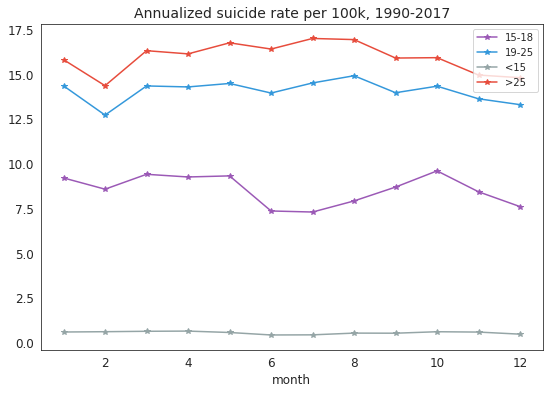

In [314]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

suicide_rate_per100k_annualized_by_month.plot(figsize=(9, 6), style='-*', color=COLORS)
_ = plt.title('Annualized suicide rate per 100k' + year_range_str, fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.xlabel('month', fontsize=12)
_ = plt.yticks(fontsize=12)
#_ = plt.axhline(1.0, color='gray')

In [315]:
months_map = {
    1: 'Jan.',
    2: 'Feb.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'Aug.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dec.',
}

rel = (suicide_rate_per100k_annualized_by_month
 /suicide_rate_per100k_annualized_by_month.mean()
# /suicide_rate_per100k_annualized_by_month.loc[9]
)
rel = rel.rename(index=months_map)

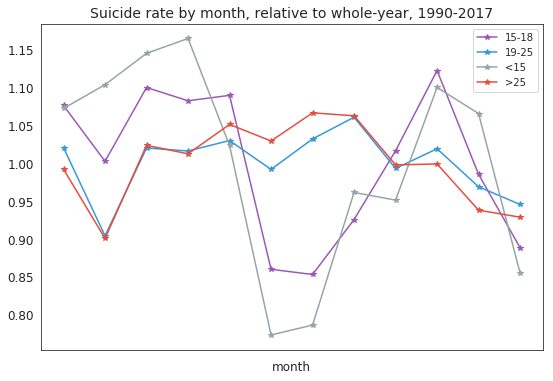

In [316]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

rel.plot(figsize=(9, 6), style='-*', color=COLORS)
_ = plt.title('Suicide rate by month, relative to whole-year' + year_range_str, fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.xlabel('month', fontsize=12)
_ = plt.yticks(fontsize=12)
#_ = plt.axhline(1.0, color='gray')

In [44]:
suicide_rate_per100k_annualized_by_month

,15-18,19-25,<15,>25
month,,,,
1,8.354390,13.494667,0.618279,16.241302
2,7.670255,12.281440,0.599908,14.639978
3,8.301958,14.031444,0.653651,16.741817
4,8.530461,14.184952,0.720015,16.767500
5,8.382228,14.400606,0.608891,17.520171
6,6.907016,13.216498,0.445859,16.988762
7,6.522186,14.440996,0.472815,17.754160
8,7.738492,14.892690,0.535373,17.710559
9,8.194755,13.922471,0.554798,16.579858


### Regressing

In [157]:
df = suicide_rate_per100k_annualized_by_monthyear.reset_index()
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
del df['year']
del df['month']
df = df.set_index('year_month')
df = df.stack().reset_index()
df = df.rename(columns={
    'level_1': 'age_group',
    0: 'suicide_rate_per100k_annualized'
})
df['year'] = df['year_month'].str[:4]
df['month'] = df['year_month'].str[5:]

In [158]:
df.head()

,year_month,age_group,suicide_rate_per100k_annualized,year,month
0,2000-1,15-18,8.308629,2000,1
1,2000-1,19-25,12.674456,2000,1
2,2000-1,<15,0.716657,2000,1
3,2000-1,>25,14.529730,2000,1
4,2000-2,15-18,7.715155,2000,2


In [160]:
reg = sm.OLS.from_formula(data=df, formula='suicide_rate_per100k_annualized ~ C(month) + C(year) + C(age_group)').fit()